In [1]:
import os
from typing import Any

import cv2 as cv
import matplotlib.pyplot as plt
from cv2.typing import MatLike
from numpy import array, intp, ones, signedinteger, uint8, unique

In [2]:
def preprocess_image(image: MatLike) -> MatLike:
    """Preprocess image to make it ready for contouring

    Args:
        image (MatLike): Original image without any filters applied on it

    Returns:
        MatLike: Preprocessed image
    """
    img = image.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Detect whether the image has colors
    lower_black = array([0, 0, 0])
    upper_black = array([180, 255, 50])
    # Define the range for gray colors in HSV
    lower_gray = array([0, 0, 50])
    upper_gray = array([180, 50, 200])
    # Define the range for white colors in HSV
    lower_white = array([0, 0, 200])
    upper_white = array([180, 50, 255])
    # Create masks for black, gray, and white colors
    black_mask = cv.inRange(img_hsv, lower_black, upper_black)
    gray_mask = cv.inRange(img_hsv, lower_gray, upper_gray)
    white_mask = cv.inRange(img_hsv, lower_white, upper_white)
    # Combine the masks
    combined_mask = cv.bitwise_or(black_mask, gray_mask)
    combined_mask = cv.bitwise_or(combined_mask, white_mask)
    # Invert the mask to get non-gray colors
    non_gray_mask = cv.bitwise_not(combined_mask)
    # Check if there are any non-gray pixels
    if non_gray_mask.any():
        print("image contains colors")
        LOWER_COLOR = array([0, 30, 60])
        UPPER_COLOR = array([20, 150, 255])
        mask = cv.inRange(img_hsv, LOWER_COLOR, UPPER_COLOR)
        kernel = ones((5, 5), uint8)
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
        mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
        inpainted_image = cv.inpaint(
            img_hsv, mask, inpaintRadius=3, flags=cv.INPAINT_TELEA
        )
        img_gray = cv.cvtColor(inpainted_image, cv.COLOR_BGR2GRAY)
        _, img_gray = cv.threshold(img_gray, 50, 255, cv.THRESH_BINARY)
        plt.imshow(img_gray, cmap="gray")

    # _, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
    img_blurred = cv.medianBlur(
        cv.blur(img_gray, (3, 3)), 3
    )  # Blur image to reduce salt and pepper noise
    _, img_denoised = cv.threshold(
        img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
    )  # OTSU threshhold to remove contrast, low/high brightness and noise problems

    # Test whether the image contains sin wave noise
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (50, 1))
    img_dilated = cv.morphologyEx(img_denoised, cv.MORPH_DILATE, kernel)
    if len(unique(img_dilated)) > 1:
        print("image contains sin wave noise")
        # Remove any colorful objects from the image
        img_denoised = cv.adaptiveThreshold(
            img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
        )

    return img_denoised

In [3]:
def find_barcode_contours(image: MatLike) -> tuple[signedinteger[Any], int, int] | None:
    """Attempt to find the contours of a barcode within the image.

    Args:
        image (MatLike): _description_

    Returns:
        tuple[signedinteger[Any], int, int] | None: _description_
    """
    img = image.copy()

    # Preprocess image for contour detection
    img_edges = cv.Canny(img, 100, 200)  # Detect edges
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    img_closed = cv.morphologyEx(
        img_edges, cv.MORPH_CLOSE, kernel
    )  # close the edges to obtain a mask for the barcode
    _, img_closed_binary = cv.threshold(
        img_closed, 50, 255, cv.THRESH_BINARY
    )  # binarize the image

    contours, _ = cv.findContours(
        img_closed_binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )
    if len(contours):
        largest_contour = max(
            contours, key=cv.contourArea
        )  # Get the largest contour assuming, after preprocessing, that it is the barcode
        rect = cv.minAreaRect(
            largest_contour
        )  # Get the minimum area rotated bounding rectangle
        box = cv.boxPoints(rect)  # Get the four rectangles four points
        box = intp(box)  # Convert all coordinates to integers

        # Draw the bounding box on the original image
        img_colored = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        img_colored = cv.drawContours(img_colored, [box], 0, (0, 255, 0), 2)
        # plt.imshow(img_colored)

        # Get the width and height of the bounding box
        width = int(rect[1][0])
        height = int(rect[1][1])

        return box, width, height
    print("No contours were found")
    return None, None, None

In [4]:
def vertical_erosion_dilation(image):
    """
    Perform vertical erosion and then vertical dilation on an input image.

    Args:
        image (numpy.ndarray): The input image (Mat-like object) as a NumPy array.

    Returns:
        numpy.ndarray: The image after vertical erosion and dilation.
    """
    if image is None:
        raise ValueError("Input image cannot be None")

    # Create a vertical kernel
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))  
    kernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 1000))  


    # Perform vertical erosion
    eroded = cv.erode(image, kernel, iterations=3)

    # Perform vertical dilation
    dilated = cv.dilate(eroded, kernel, iterations=3)

    dilated2 = cv.dilate(dilated, kernel2, iterations=3)

    return dilated2

In [5]:
def extract_barcode(image: MatLike) -> MatLike | None:
    """Extract barcode from an image

    Args:
        image (MatLike): Original image

    Returns:
        MatLike | None: Barcode image if found. Otherwise returns None
    """

    cleaned_img = preprocess_image(image)  # Preprocess the image

    bounding_box, width, height = find_barcode_contours(cleaned_img)

    if bounding_box is not None:
        destination_points = array(
            [[0, height - 1], [0, 0], [width - 1, 0], [width - 1, height - 1]],
            dtype="float32",
        )
        M = cv.getPerspectiveTransform(
            bounding_box.astype("float32"), destination_points
        )  # Get the perspective transform matrix
        warped = cv.warpPerspective(cleaned_img, M, (width, height))
        warped_rotated = cv.rotate(warped, cv.ROTATE_90_CLOCKWISE)

        eroded_and_dilated = vertical_erosion_dilation(warped_rotated)

        return eroded_and_dilated
    print("No contour was found")
    return None


In [6]:
def plot_image(
    file_name: str, original_image: MatLike, barcode_image: MatLike | None = None
) -> None:
    """Plot the original image and the barcode extrracted from it

    Args:
        file_name (str): Name of the image file
        original_image (MatLike): Original image without any preprocessing
        barcode_image (MatLike | None, optional): Extracted barcode image if found. Defaults to None.
    """
    plt.figure(figsize=(15, 20))

    plt.subplot(1, 2, 1)
    plt.title(f"Processed {file_name}")
    plt.axis("off")
    plt.imshow(original_image, cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title(f"{file_name} Extracted Barcode")
    plt.axis("off")
    if barcode_image is not None:
        plt.imshow(barcode_image, cmap="gray")
    else:
        print(f"No barcode detected for {file_name}.")

    plt.show()

In [7]:
def extract_barcodes(
    images_dir: str, output_dir: str = r".\processed_barcodes"
) -> None:
    """Extract a barcode from each image in the images directory and saves the result as an image in output directory

    Args:
        images_dir (str): Path to the directory that contains the images to extract barcodes from
        output_dir (str, optional): Path to the directory to save the images of barcodes in. Defaults to r".\processed_barcodes".
    """

    IMAGE_FILES_EXTENSIONS = {
        ".png",
        ".jpg",
        ".jpeg",
        ".bmp",
        ".tiff",
        ".tif",
    }  # List of valid image extensions for OpenCV

    for file_name in os.listdir(images_dir):  # Iterate over files in the directory
        ext = os.path.splitext(file_name)[1].lower()  # Get the file extension
        if ext in IMAGE_FILES_EXTENSIONS:  # Check if the file is an image
            print(f"Processing: {file_name}")
            image_path = os.path.join(images_dir, file_name)
            image = cv.imread(image_path)
            barcode = extract_barcode(image)  # Extract barcode
            plot_image(
                file_name, image, barcode
            )  # Plot original image and extracted barcode
        else:
            print(f"{file_name} is not an image file.")

Processing: 01 - lol easy.jpg


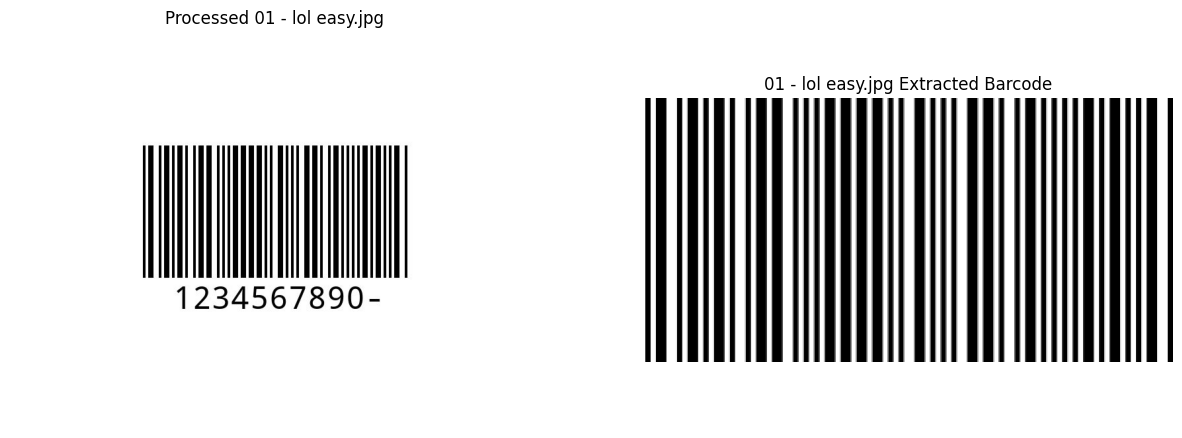

Processing: 02 - still easy.jpg


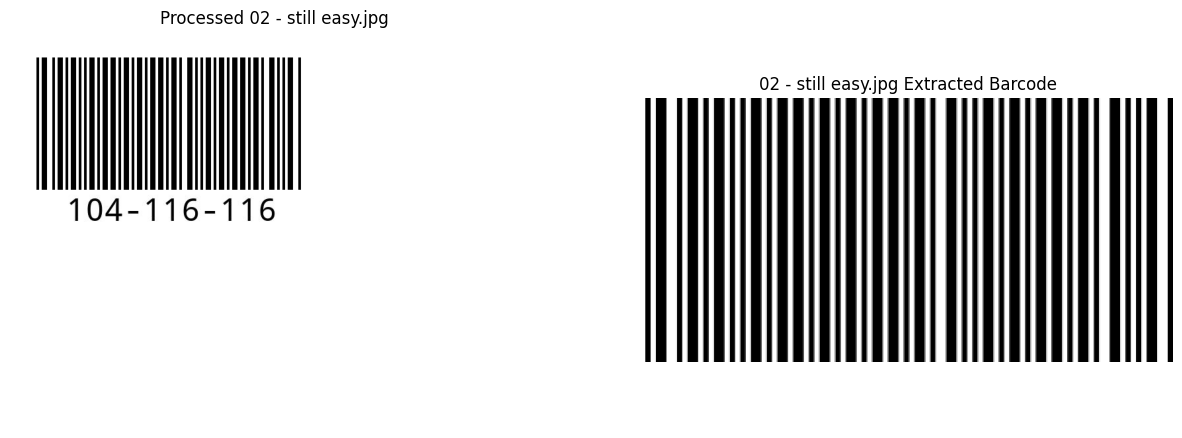

Processing: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg
image contains colors


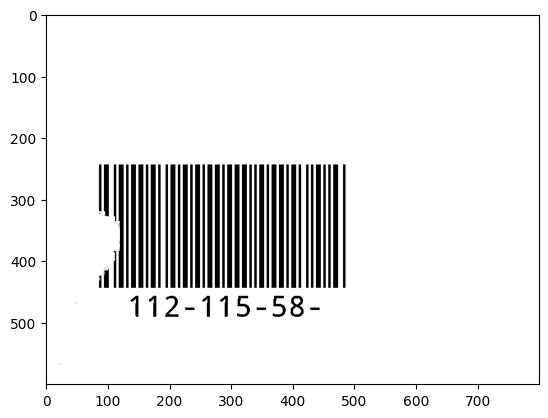

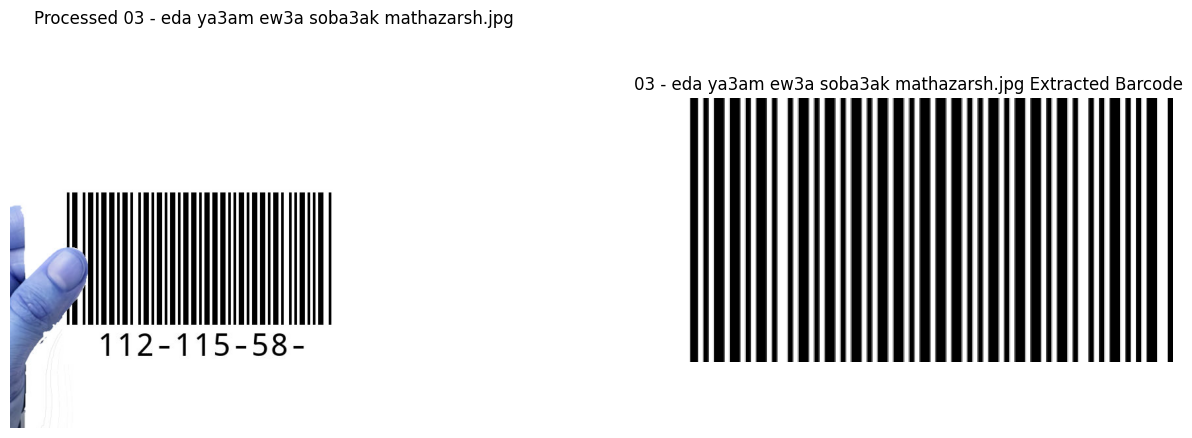

Processing: 04 - fen el nadara.jpg


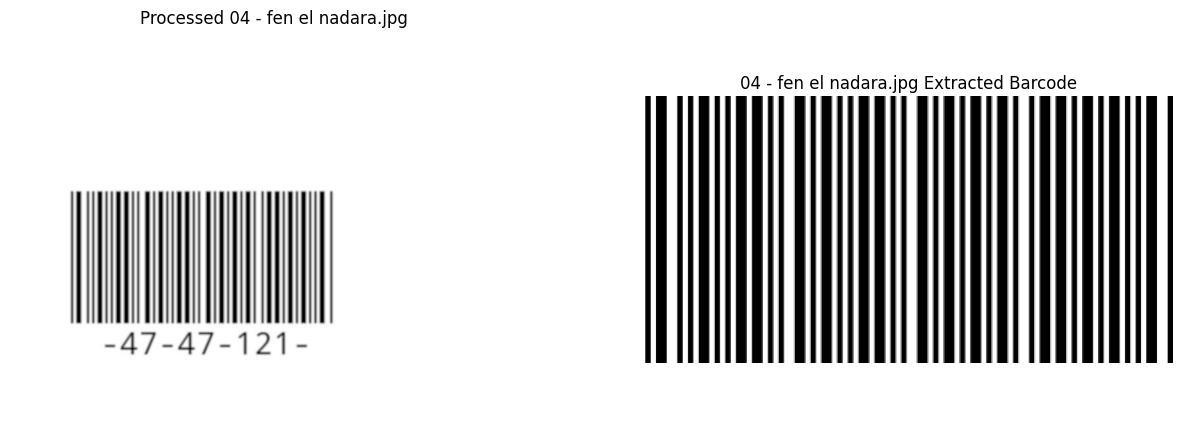

Processing: 05 - meen taffa el nour!!!.jpg


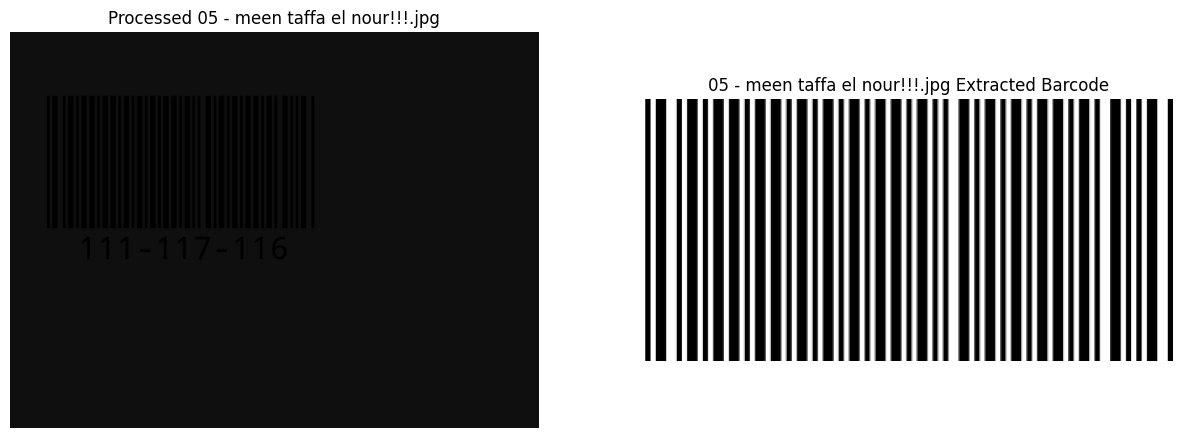

Processing: 06 - meen fata7 el nour 333eenaaayy.jpg


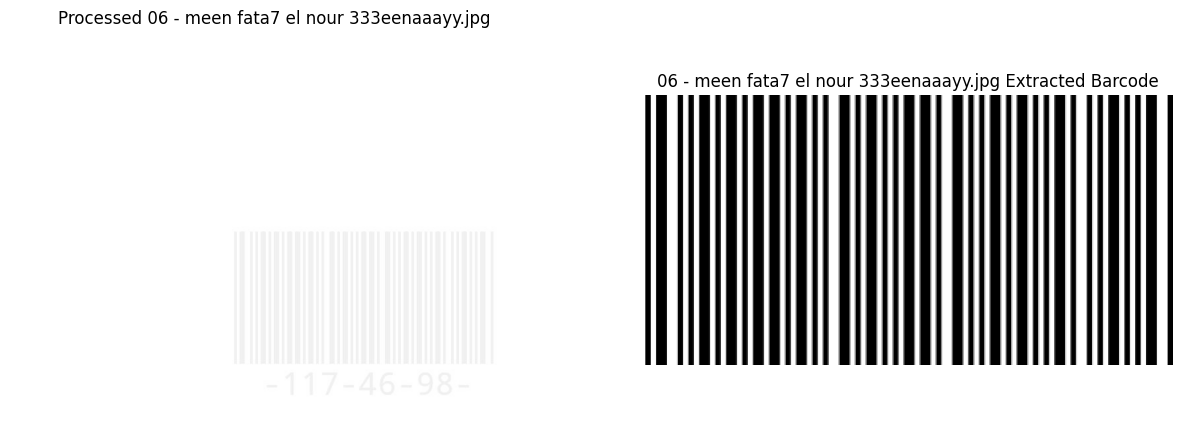

Processing: 07 - mal7 w felfel.jpg


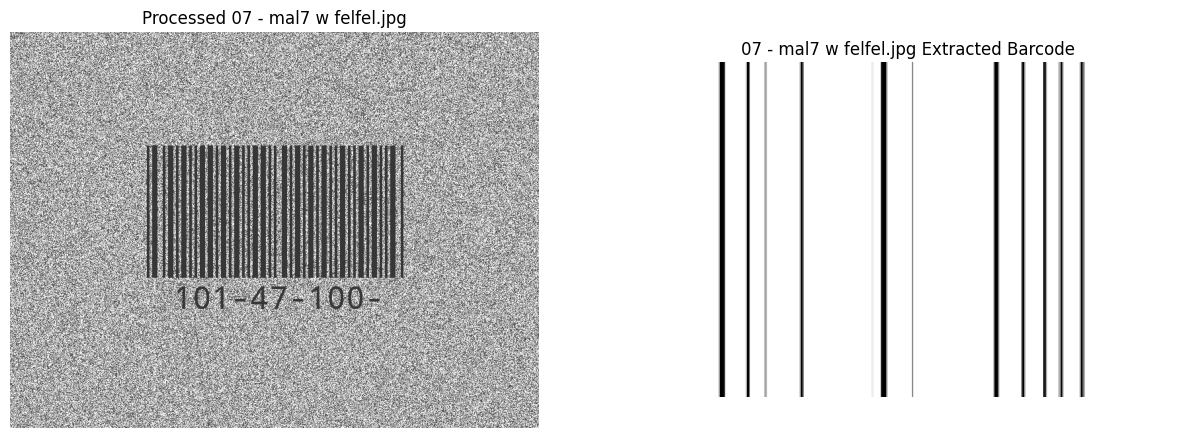

Processing: 08 - compresso espresso.jpg


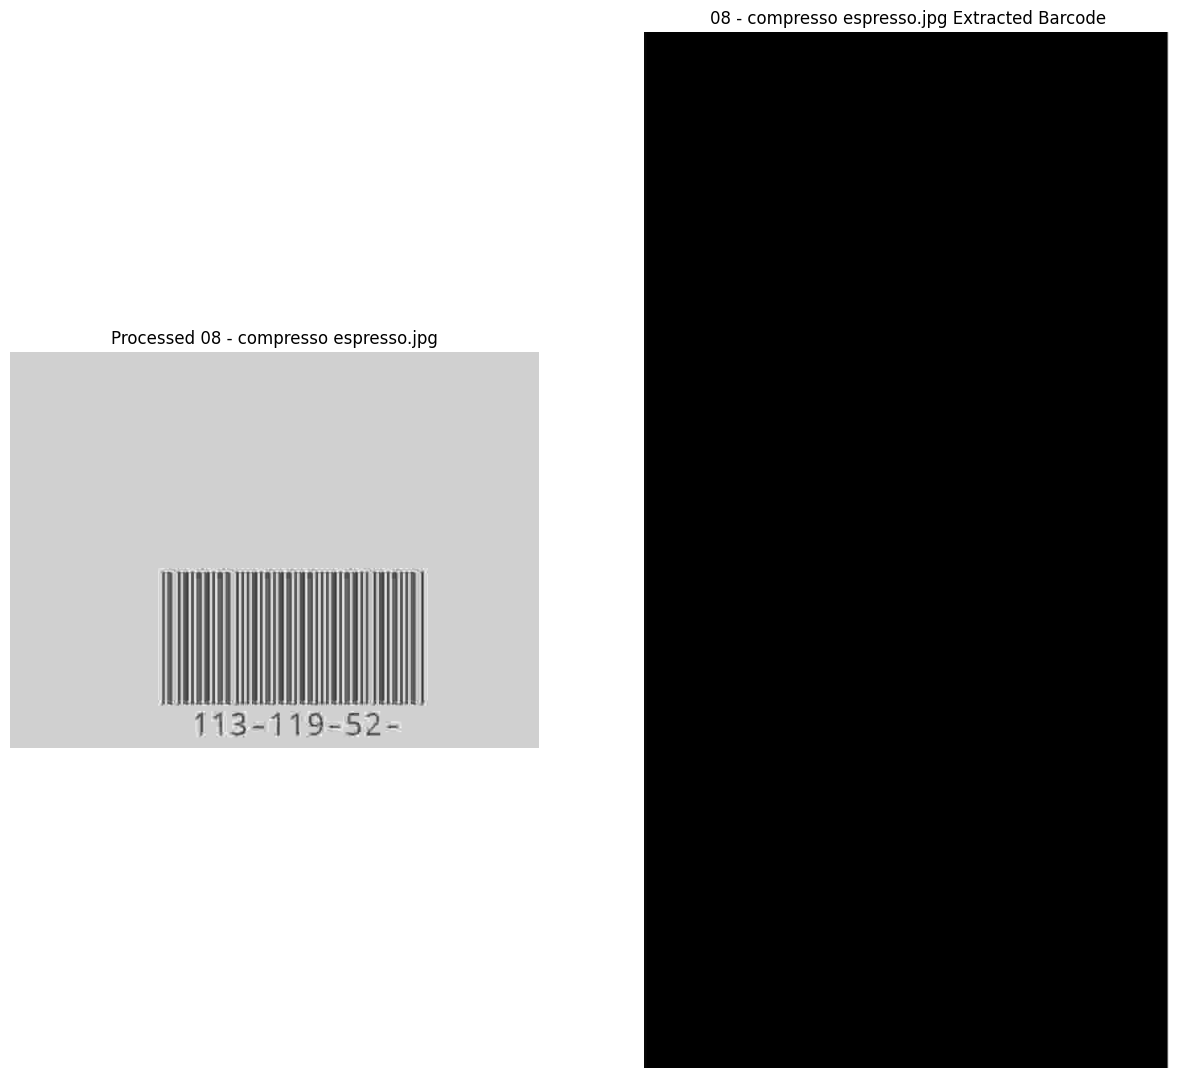

Processing: 09 - e3del el soora ya3ammm.jpg


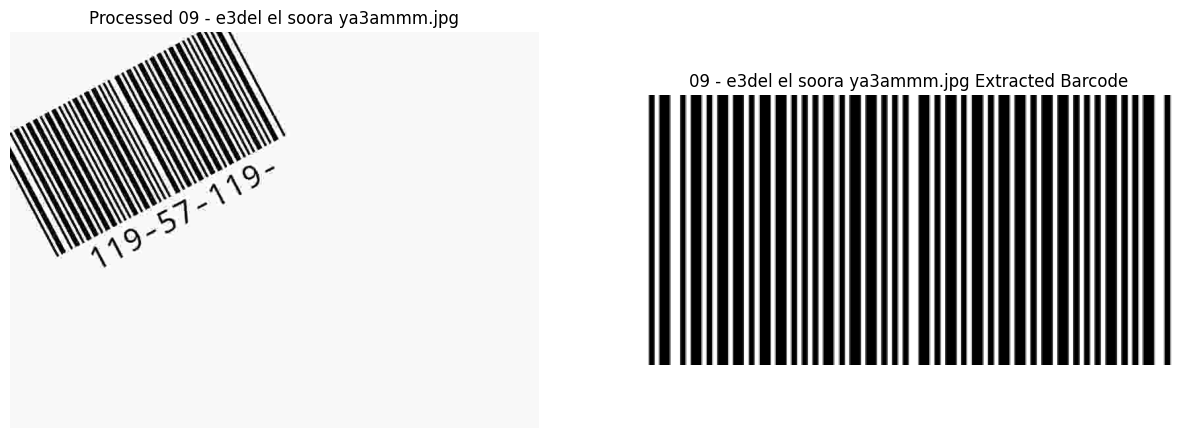

Processing: 10 - wen el kontraastttt.jpg


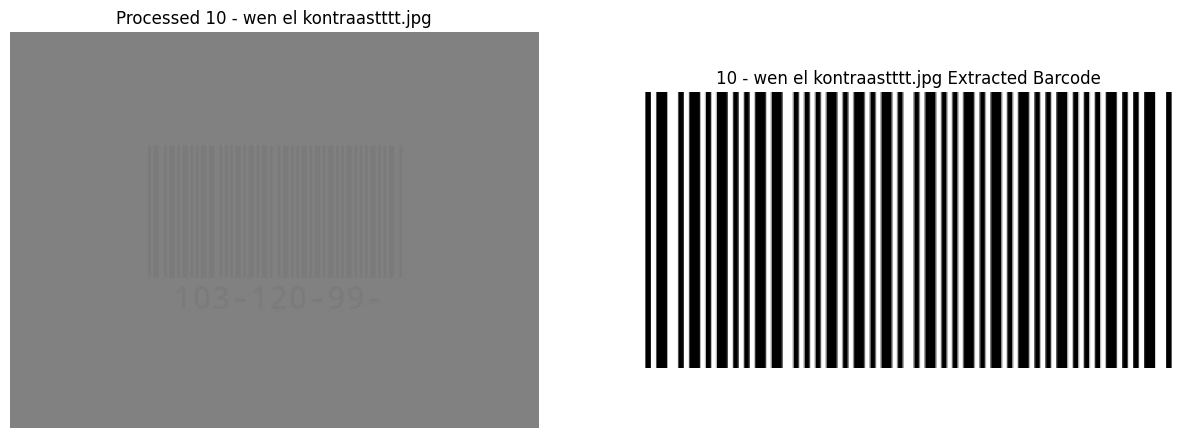

Processing: 11 - bayza 5ales di bsara7a.jpg
image contains sin wave noise


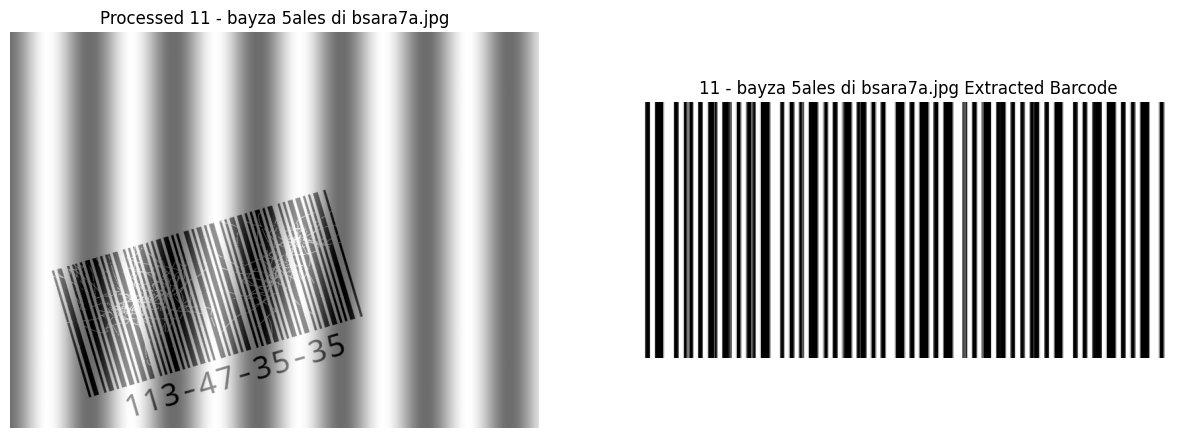

processed_barcodes is not an image file.


In [8]:
# Define the folder containing the test images
IMAGES_DIR = r".\test_cases"

# Specify the output folder where you want to save the extracted barcodes
OUTPUT_DIR = os.path.join(IMAGES_DIR, "processed_barcodes")

# Ensure the output folder exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Process all test images
extract_barcodes(IMAGES_DIR, OUTPUT_DIR)

In [ ]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Get the average of each column in your image
mean = your_cropped_image.mean(axis=0)

# Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

# Convert to string of pixels in order to loop over it
pixels = "".join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):
    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    current_digit_widths += NARROW if count == narrow_bar_size else WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

NameError: name 'your_cropped_image' is not defined